In [0]:
# imports.
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [61]:
# read in the data.
df = pd.read_csv('https://raw.githubusercontent.com/spotify-song-suggester-1/spotify-app/master/ds/Data/Spotify_MoodsData.csv', index_col=0)
print(df.shape)
df.head()

(16, 21)


,artist_name,track_name,track_id,popularity,year,genre,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,mood
48618,Rise Against,Like the Angel,4t2rjxCXIJnBmRBkXJOYa5,48,2013,grunge,80061,0.000747,0.512,166880,0.976,0.000025,10,0.2150,-3.092,0,0.0861,95.465,4,0.428,Excited
55603,Mac Miller,BDE (Best Day Ever) - Live,504jTZvXdP8YYVtd19rfuX,40,2013,rap,92664,0.008290,0.434,321960,0.862,0.000052,2,0.9460,-9.589,1,0.1020,96.205,4,0.262,Happy
68155,Justin Bieber,All That Matters,70XP39KE8vTgxtRXcwfxJA,59,2014,pop,111926,0.005080,0.696,191173,0.513,0.000000,6,0.0682,-5.567,0,0.0424,129.859,4,0.144,Motivated
73129,Zac Brown Band,Castaway,5PNcJn4oFNvlRfrZBHfqWh,58,2015,country,121789,0.149000,0.611,188053,0.782,0.000000,8,0.1150,-4.989,1,0.0475,101.313,4,0.915,Happy
74887,Fifth Harmony,Worth It,41Fflg7qHiVOD6dEPvsCzO,73,2015,dance,123771,0.063000,0.884,224573,0.765,0.000007,8,0.1180,-3.865,1,0.0882,99.987,4,0.594,Im a boss


In [62]:
# new data frame with encoded genre column.
moodframe = pd.concat([df,pd.get_dummies(df['mood'], prefix='mood')],axis=1)
# show only the audio features.
moodframe.iloc[0,7:20]

acousticness        0.000747
danceability           0.512
duration_ms           166880
energy                 0.976
instrumentalness    2.52e-05
key                       10
liveness               0.215
loudness              -3.092
mode                       0
speechiness           0.0861
tempo                 95.465
time_signature             4
valence                0.428
Name: 48618, dtype: object

In [63]:
# set the X_train data on the audio features.
X_train = moodframe.iloc[:,7:20].to_numpy()
# set the standard scalar 
scaler = StandardScaler()
# fit the scalar on the X_train data.
X_scaled = scaler.fit_transform(X_train)
# show the X_scaled array.
print(X_scaled.shape)

(16, 13)


In [64]:
# create a list of the genres.
mood = df.mood.unique().tolist()
mood

['Excited',
 'Happy',
 'Motivated',
 'Im a boss',
 'Unwind & Relax',
 'Mad Energized',
 'Calming',
 'Head Bobbers',
 'Wake Up']

In [65]:
# set the y_train with onehots.
onehots = moodframe.iloc[:,21:]
y_train = onehots.to_numpy()
# show the array.
print(y_train.shape)
y_train

(16, 9)


array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=uint8)

### NN Model.

In [0]:
# function for NN model.
def create_model():
      # set the model.
    model = Sequential()
    # hidden layers.
    model.add(Dense(144, input_dim=13, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(72, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(36, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(18, kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(9, kernel_initializer='glorot_normal', activation='softmax'))
    # function for top 3.
    def top_3_accuracy(y_true, y_pred):
        return top_k_categorical_accuracy(y_true, y_pred, k=3)

    # set the optimizer.
    optimizer = SGD(lr=0.0)
    # compile the model.
    model.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    return model

In [0]:
# set the model.
model = create_model()
# fit the model, create history.
history = model.fit(X_scaled, y_train, validation_split=0.2, epochs=500, batch_size=8, verbose=0)

In [92]:
# final model accuracy score.
scores = model.evaluate(X_scaled, y_train)

16/16 [==============================] - 0s 407us/sample - loss: 2.2421 - acc: 0.1250


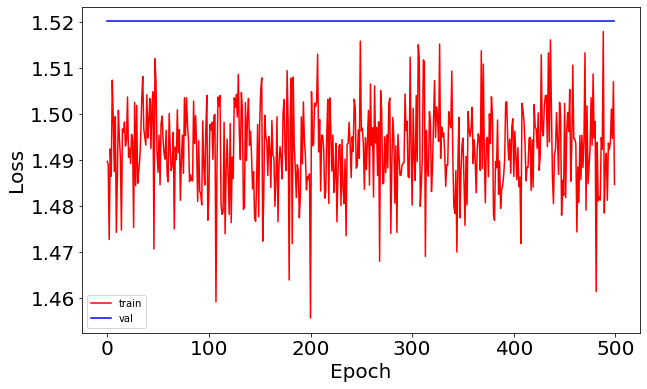

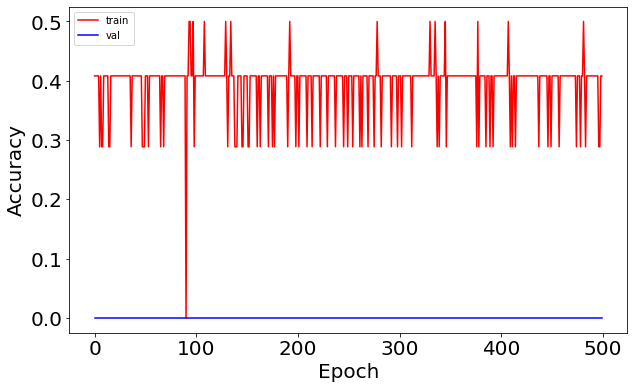

In [93]:
# plot the model loss.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# plot the model accuracy.
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### Results.

In [94]:
# get a single observation and all features.
obs = moodframe.iloc[12:13,7:20].to_numpy()
print(obs.shape)

(1, 13)


In [95]:
# use the model to predict the observation.
model.predict(obs)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [96]:
# get the single observation genre.
moodframe.iloc[12:13,20]

131059    Head Bobbers
Name: mood, dtype: object

In [0]:
# save the model.
model.save('mood_NN')